In [1]:
#from bert_serving.client import BertClient
import numpy as np
import pandas as pd
import nltk
Porter = nltk.stem.PorterStemmer()
import csv
import pickle
import re
import random
from gensim.models.word2vec import Word2Vec
from gensim.models.fasttext import FastText
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn import preprocessing
from scipy import spatial
import pickle

In [2]:
def readfile(filename,method='utf-8'):
    rawlist = []
    with open(filename,'r+', encoding=method) as csvfile:
        rows = csv.reader(csvfile)
        for row in rows:
            rawlist.append(row)
    return rawlist

def writefile(filename,inputlist,method='utf-8'):
    with open(filename,'a+', encoding=method) as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        for row in inputlist:
            writer.writerow(row)
            
def regex(a):
    reg = []
    #a = re.sub('[a-zA-Z]','',a)
    a = re.sub('[,、：；！？，。－"\']','#',a)
    a = re.sub('[「」(){}:;!?]','',a)
    a = re.sub('\n','',a)
    #a = re.sub('[(),{}\u3000\*\|=-\[\]\n.]','',a)
    #a = re.sub(u"\\（.*?\\）|\\『.*?』|\\「.*?」|\\〔.*?〕|\\[.*?]|\\〈.*?〉", '', a)
    reg = a.split('#')
    return reg

def en_regex(a):
    #a = re.sub('[a-zA-Z]','',a)
    a = re.sub('[(){}.:,;!?：；！？，。－"\']','',a)
    #a = re.sub(',',' ',a)
    #a = re.sub('\n','',a)
    #a = re.sub('[(),{}\u3000\*\|=-\[\]\n.]','',a)
    #a = re.sub(u"\\（.*?\\）|\\『.*?』|\\「.*?」|\\〔.*?〕|\\[.*?]|\\〈.*?〉", '', a)
    if not a.find('to ')==-1:
        a = a[a.find('to ')+3:]
    return a

def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

In [3]:
#bc = BertClient()

In [62]:
with open('cleaner_dict.pickle','rb') as f:
    adict = pickle.load(f)
len(adict)

50009

In [60]:
#FTzh = FastText.load('FTzh.model')
#FTen = FastText.load('FTen.model')
CBzh = Word2Vec.load('CBzh0505.model')
CBen = Word2Vec.load('CBen0505.model')
#SGzh = Word2Vec.load('SGzh.model')
#SGen = Word2Vec.load('SGen.model')

In [61]:
with open('airiti_english_corpus.pickle','rb') as f:
    en_data = pickle.load(f)
with open('airiti_chinese_corpus.pickle','rb') as f:
    zh_data = pickle.load(f)

In [6]:
def makedic(data):
    dic = {}
    for i in range(0,len(data)):
        for word in data[i]:
            if word not in dic:
                dic[word] = 1
            else:
                tmp = dic[word]
                dic[word] = tmp+1
    return dic

In [7]:
def processing(rawdata):
    tmp = []
    final = []
    for i in range(0,len(rawdata)):
        for j in range(0,len(rawdata[i])):
            for item in rawdata[i][j]:
                if not item == '':
                    tmp.append(item)
        final.append(tmp)
        tmp = []
    return final

In [8]:
def findpairs(source,dic):
    pairs = []
    for word in source:
        freq = source[word]
        try:
            means = dic[word]
        except:
            continue
        #print(len(means))
        #if len(means)==1 and isEnglish(means[0]) and len(means[0])>=2:
        #    tmp = en_regex(means[0]).strip()
        #    if not len(tmp.split())>3 and not len(tmp)>20:
        #        pairs.append([word,tmp,freq])
        if not len(means)==0 and isEnglish(means[0]) and len(means[0])>=2:
            tmp = en_regex(means[0]).strip()
            if not len(tmp.split())>3 and not len(tmp)>20 and freq>10:
                pairs.append([word,tmp,freq])
    return pairs

In [63]:
newdict = dict()
for word in adict:
    if not adict[word] == []:
        for means in adict[word]:
            if not ' ' in means:
                tmp.append(means.lower())
        if not tmp == []:
            newdict[word] = tmp
        tmp = []
len(newdict)

50009

In [64]:
#with open('cleaner_dict.pickle','wb') as f:
#    pickle.dump(newdict,f,protocol=pickle.HIGHEST_PROTOCOL)

In [65]:
alist = []
for key, value in newdict.items():
    temp = [key,value]
    alist.append(temp)

In [66]:
zhf = processing(zh_data)
enf = processing(en_data)
zhdic = makedic(zhf)
endic = makedic(enf)

In [67]:
pairs = sorted(findpairs(zhdic,newdict),key=lambda x:x[2],reverse=True)
len(pairs)

6771

In [68]:
def make_pairvector(pairs,zhmodel,enmodel):
    pairvector = []
    for i in range(0,len(pairs)):
        add = 1
        if not pairs[i][1] == '':
            try:
                ch = zhmodel[pairs[i][0]]
                en = enmodel[pairs[i][1]]
            except:
                #print(pairs[i][1],'not found')
                add = 0
        if add==1:
            pairvector.append([ch,en,pairs[i][0],pairs[i][1]])
    return pairvector

In [69]:
def pairs_for_ml(pairvector):
    chcombined = []
    encombined = []
    for i in range(0,len(pairvector)):
        chcombined.append(np.asarray(pairvector[i][0]))
        encombined.append(np.asarray(pairvector[i][1]))
    zh = np.array(chcombined)
    en = np.array(encombined)
    return(zh,en)

In [75]:
#FTpv = make_pairvector(pairs,FTzh,FTen)
CBpv = make_pairvector(pairs[1:],CBzh,CBen)
#SGpv = make_pairvector(pairs,SGzh,SGen)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [76]:
#FTcpac,FTepac = pairs_for_ml(FTpv)
CBcpac,CBepac = pairs_for_ml(CBpv)
#SGcpac,SGepac = pairs_for_ml(SGpv)
np.shape(CBcpac)

(5797, 200)

In [49]:
def cal_cost(theta,X,y,method='MSE'):
    m = len(y)
    cost = 0
    if method == 'ED':
        #eucilidean distance
        for i in range(m):
            cost = cost + np.sqrt(np.sum(np.square(np.dot(X[i],theta) - y[i])))
            #print(cost)
        #print('XXX')
        cost = 1/(2*m)*cost
    else:
        y_pred = []
        for i in range(m):
            y_pred.append(np.dot(X[i],theta))
        mse = mean_squared_error(y, y_pred)
        cost = np.sum(mse)
    return cost

In [50]:
def gradient_descent(X,y,theta,learning_rate=0.01,iterations=100,how='MSE'):
    m = len(y)
    print('訓練資料組數 =',m)
    cost_history = np.zeros(iterations)
    #theta_history = np.zeros((iterations,768,768))
    for it in range(iterations):
        prediction = np.dot(X,theta)
        result = prediction-y
        theta = theta - (1/m)*learning_rate*(np.dot(X.T,result))   
        #theta_history[it,:] = theta.T
        cost_history[it]  = cal_cost(theta,X,y,method=how)
        if it%1000==0:
            print(it,cost_history[it])
    #return theta, cost_history, theta_history
    return theta, cost_history

In [77]:
theta = np.zeros((200,200))
#FastText, FTcost_history = gradient_descent(FTcpac,FTepac,theta,0.001,10000)
Cbow, CBcost_history = gradient_descent(CBcpac,CBepac,theta,0.001,10000)
#Skipgram, SGcost_history = gradient_descent(SGcpac,SGepac,theta,0.001,10000)

訓練資料組數 = 5797
0 1.313330865946302
1000 1.1076662111113915
2000 1.0964231629573724
3000 1.0934245084076724
4000 1.0921341310997057
5000 1.0913641225729718
6000 1.090812224208383
7000 1.0903815059348794
8000 1.090032812733321
9000 1.0897460533568708


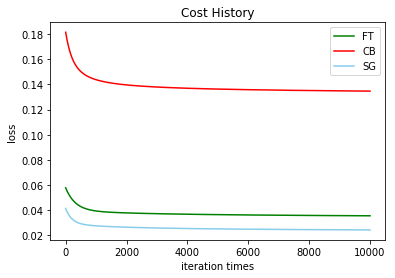

In [214]:
#plt.plot(FTcost_history)
#plt.plot(CBcost_history)
#plt.plot(SGcost_history)

plt.title('Cost History')
plt.plot(FTcost_history, color='green', label='FT')
plt.plot(CBcost_history, color='red', label='CB')
plt.plot(SGcost_history,  color='skyblue', label='SG')
plt.legend() # 显示图例
plt.xlabel('iteration times')
plt.ylabel('loss')
plt.show()

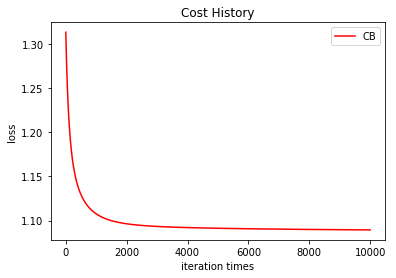

In [89]:
plt.title('Cost History')
plt.plot(CBcost_history, color='red', label='CB')
plt.legend() # 显示图例
plt.xlabel('iteration times')
plt.ylabel('loss')
plt.show()

In [89]:
#Best For Now
#trans_matrix100, cost_history100 = gradient_descent(chcombined[:100],encombined[:100],theta,0.001,5000)

In [90]:
target_vector = ['一','二','三','四','五','六','七','八','九']
target_vectorname = ['1','2','3','4','5','6','7','8','9']
#target_vector = ['紅色','綠色','藍色','黃色','紫色','白色','黑色','橙色']
#target_vectorname = ['red','green','blue','yellow','purple','white','black','orange']

In [186]:
pairs = sorted(pairs)
ans = [[],[],[]]
print("%s %6s  %6s  %6s" % ('ch','Ftxt','Cbow','Skip'))
print('-------------------------')
for line in FTpv:
    if line[2] in target_vector:
        #ans[0].append(1-spatial.distance.cosine(line[0],line[1]))
        ans[0].append(1-spatial.distance.cosine(np.dot(line[0],FastText),line[1]))
for line in CBpv:
    if line[2] in target_vector:
        ans[1].append(1-spatial.distance.cosine(np.dot(line[0],Cbow),line[1]))
for line in SGpv:
    if line[2] in target_vector:
        ans[2].append(1-spatial.distance.cosine(np.dot(line[0],Skipgram),line[1]))
for i in range(0,len(target_vector)):
    print("%s  %.4f  %.4f  %.4f" % (target_vector[i],ans[0][i],ans[1][i],ans[2][i]))

ch   Ftxt    Cbow    Skip
-------------------------
一  0.4246  0.7708  0.4378
二  0.5194  0.9367  0.6094
三  0.4909  0.8709  0.5264
四  0.5431  0.9176  0.6320
五  0.5644  0.8925  0.6677
六  0.5987  0.8723  0.6691
七  0.6084  0.7784  0.7395
八  0.6552  0.7975  0.7371
九  0.5891  0.7556  0.7609


In [56]:
def draw_scatter_plot(Df,tag,col='yellow'):
    plt.subplots_adjust(bottom = 0.1)
    plt.scatter(Df['component 1'], Df['component 2'])
    for label, x, y in zip(tag,Df['component 1'],Df['component 2']):
        plt.annotate(
            label,
            xy=(x, y), xytext=(-20, 20),
            textcoords='offset points', ha='right', va='bottom',
            bbox=dict(boxstyle='round,pad=0.5', fc=col, alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    plt.show()

In [92]:
def precision_at_5_experiment(target,model,pairvector,trans_matrix):
    pca = PCA(n_components=2)
    cv = []
    output = []
    noutput = []
    for word in target:
        for i in range(0,len(pairvector)):
            if word == pairvector[i][2]:
                vec = model[word]
                cv.append(np.dot(vec,trans_matrix))
                break        
    for i in range(0,len(cv)):
        for j in range(0,len(pairvector)): 
            cos = 1-spatial.distance.cosine(cv[i],pairvector[j][1])
            output.append([cos,pairvector[j][3]])
        output = sorted(output,reverse=True)
        for x in range(0,len(output)):
            if not output[x][1] == output[x-1][1]:
                noutput.append(output[x]) 
        print(target[i])
        for x in range(0,5):
            print(noutput[x])
        output = []
        noutput = []

In [115]:
tvec = ['至少','最後','我們','機器']
#precision_at_5_experiment(tvec,FTzh,FTpv,FastText)
precision_at_5_experiment(tvec,CBzh,CBpv,Cbow)
#precision_at_5_experiment(tvec,SGzh,SGpv,Skipgram)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


至少
[0.5341732785139035, 'least']
[0.4562930195996582, 'thousand']
[0.45037678003596815, 'all']
[0.4156678758316099, 'only']
[0.4055883701245452, 'million']
最後
[0.6939192705786202, 'finally']
[0.5283151995907395, 'then']
[0.48052122559984256, 'first']
[0.4744112110571479, 'final']
[0.45787446638491014, 'paper']
我們
[0.6639238543108943, 'we']
[0.5440804790869054, 'finally']
[0.5428588449379368, 'here']
[0.45501325229861744, 'paper']
[0.4445625849911745, 'framework']
機器
[0.5693036607028524, 'robot']
[0.5346242417298005, 'machine']
[0.5092903609969007, 'system']
[0.4966083362092393, 'camera']
[0.47960254630071564, 'vehicle']


In [221]:
def exp1(pairvector,trans_matrix):
    cost = 0
    for i in range(0,len(pairvector)):
        if pairvector[i][2] in tvec:
            #cost = cost + np.sqrt(np.sum(np.square(np.dot(pairvector[i][0],trans_matrix) - pairvector[i][1])))
            #print(cost)
            tmp = np.dot(pairvector[i][0],trans_matrix)
            print(pairvector[i][2],pairvector[i][3],1-spatial.distance.cosine(tmp,pairvector[i][1]))

In [223]:
print('FastText')
exp1(FTpv,FastText)
print('Cbow')
exp1(CBpv,Cbow)
print('Skipgram')
exp1(SGpv,Skipgram)

FastText
論文 paper 0.576124019679362
管理 supervise 0.6647021927229927
電腦 computer 0.6693576657387231
醫學 medicine 0.7549030919048689
中國 China 0.7391015138060255
Cbow
論文 paper 0.9250620289915188
管理 supervise 0.4910860972275758
電腦 computer 0.844917873882037
醫學 medicine 0.7859497952124085
中國 China 0.8340624538765047
Skipgram
論文 paper 0.5880199023045968
管理 supervise 0.82973481144601
電腦 computer 0.7431381497251588
醫學 medicine 0.7765523807749632
中國 China 0.7803549028208635


In [54]:
def scatter_plot_experiment(pairvector,target,tag,trans_matrix):
    ev = []
    cv = []
    pca = PCA(n_components=2)
    for dom in target:
        for line in pairvector:
            if line[2]==dom:
                #print(dom)
                ev.append(np.asarray(line[1]))
                cv.append(np.asarray(np.dot(line[0],trans_matrix)))
    ev = np.array(ev)
    cv = np.array(cv)
    evpca = pca.fit_transform(ev)
    cvpca = pca.fit_transform(cv)
    #evpca = preprocessing.scale(evpca)
    #cvpca = preprocessing.scale(cvpca)
    evDf = pd.DataFrame(data = evpca,columns = ['component 1', 'component 2'])
    cvDf = pd.DataFrame(data = cvpca,columns = ['component 1', 'component 2'])
    draw_scatter_plot(evDf,tag)
    draw_scatter_plot(cvDf,tag,'blue')

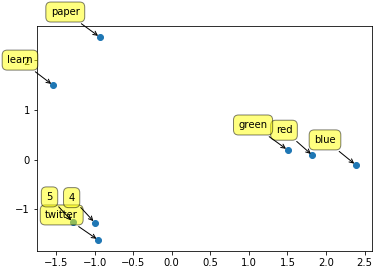

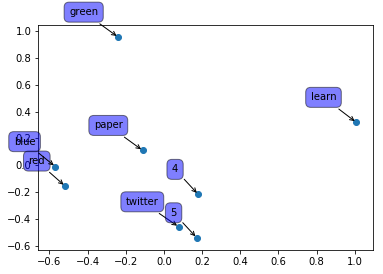

In [240]:
tvec = ['紅色','藍色','綠色','學習','論文','推特','四','五','六']
tags = ['red','blue','green','learn','paper','twitter','4','5','6']
#tvec = ['頭部','頸','鼻炎','臉部']
#tvec = ['綠色','藍色']
#tags = ['green','blue']
#tags = ['head','neck','ill','face']
scatter_plot_experiment(SGpv,tvec,tags,Skipgram)

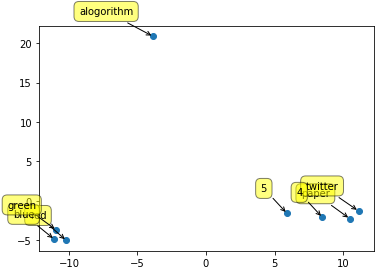

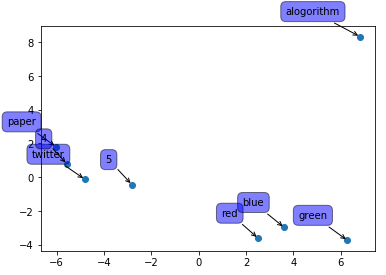

In [81]:
tvec = ['紅色','藍色','綠色','演算法','論文','推特','四','五','六','七']
tags = ['red','blue','green','alogorithm','paper','twitter','4','5','6','7']
scatter_plot_experiment(CBpv,tvec,tags,Cbow)

In [241]:
with open('FT_trans_matrix.pickle', 'wb') as f:
    pickle.dump(FastText, f)
with open('CB_trans_matrix.pickle', 'wb') as f:
    pickle.dump(Cbow, f)
with open('SG_trans_matrix.pickle', 'wb') as f:
    pickle.dump(Skipgram, f)

In [82]:
with open('0505_trans_matrix.pickle', 'wb') as f:
    pickle.dump(Cbow, f)